# How-to: Compute range-defined quasi-vertical profiles

Daniel Sanchez-Rivas<sup>1</sup> and Miguel A. Rico-Ramirez<sup>1</sup>

<sup>1</sup>Department of Civil Engineering, University of Bristol, Bristol, BS8 1TR, United Kingdom

**This notebook describes the process for generating RD-QVPs (adapted from the methodology proposed by Tobin, D. M. and Kumjian, M. R., 2017).**

### Import relevant packages

In [14]:
import datetime as dt
import os
import numpy as np
import towerpy as tp
import cartopy.crs as ccrs
from tqdm import tqdm

%matplotlib notebook

### Define working directory, file name and other parameters

In [2]:
RSITE = 'dudwick'
WDIR = f'../../../datasets/'

SCANS_ELEVS = ['spel1', 'spel2', 'spel3', 'spel4']
# SCANS_ELEVS = ['lpel0', 'lpel1', 'lpel2', 'lpel3', 'lpel4']

plot_methods = False

We'll need a list containing the path and names of the files to be used. 
Note that four elevation scans will be used to 

In [10]:
lfiles_elevs = ['../../../datasets/dudwick/2020/spel1/metoffice-c-band-rain-radar_dudwick_202010031811_raw-dual-polar-augzdr-sp-el1.dat',
                '../../../datasets/dudwick/2020/spel2/metoffice-c-band-rain-radar_dudwick_202010031811_raw-dual-polar-augzdr-sp-el2.dat',
                '../../../datasets/dudwick/2020/spel3/metoffice-c-band-rain-radar_dudwick_202010031810_raw-dual-polar-augzdr-sp-el3.dat',
                '../../../datasets/dudwick/2020/spel4/metoffice-c-band-rain-radar_dudwick_202010031810_raw-dual-polar-augzdr-sp-el4.dat'
               ]

### We initialise one towerpy object per each elevation scan.

In [13]:
# Initialise the towerpy's objects.
rdata = [tp.io.ukmo.Rad_scan(i, RSITE) for i in lfiles_elevs]

# Read-in the data
[robj.ppi_ukmoraw(exclude_vars=['W [m/s]', 'SQI [-]', 'CI [dB]'])
 for c, robj in enumerate(rdata)]

# Create a georeference grid for each object.
[robj.ppi_ukmogeoref() for c, robj in enumerate(rdata)]

Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK Met office polar radar data ...
Reading UK 

[None, None, None, None]

### S

In [12]:
rsnr = [tp.eclass.snr.SNR_Classif(robj) for robj in rdata]
[robj.signalnoiseratio(rdata[c].georef, rdata[c].params, rdata[c].vars,
                       min_snr=55, data2correct=rdata[c].vars,
                       plot_method=plot_methods)
 for c, robj in enumerate(rsnr)]

[None, None, None, None]

### As we are working with low-elevation scans, we

In [6]:
rnme = [tp.eclass.nme.NME_ID(robj) for robj in rsnr]
[robj.clutter_id(rdata[c].georef, rdata[c].params, rsnr[c].vars,
                 binary_class=159, data2correct=rsnr[c].vars,
                 plot_method=plot_methods)
 for c, robj in enumerate(tqdm(rnme, desc='NME_ID'))]

NME_ID: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.38it/s]

Clutter classification running time: 0.101 sec.
Clutter classification running time: 0.072 sec.
Clutter classification running time: 0.055 sec.
Clutter classification running time: 0.049 sec.


[None, None, None, None]

### Generate QVPs of polarimetric variables

PolProfs: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


<IPython.core.display.Javascript object>


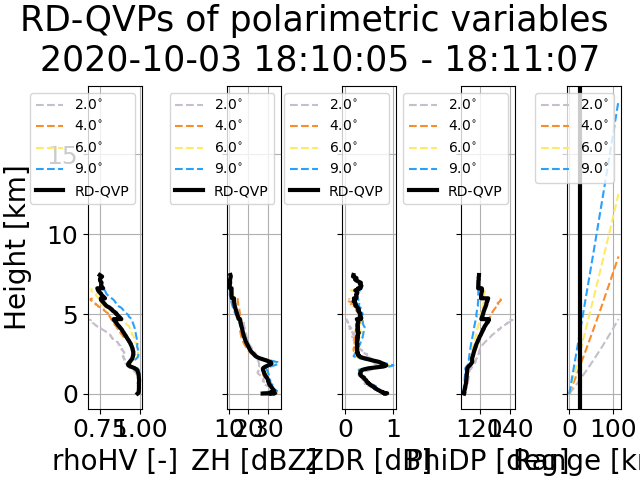

RD-QVPS running time: 0.618 sec.


In [7]:
rprofs = [tp.profs.polprofs.PolarimetricProfiles(robj) for robj in rdata]
[robj.pol_qvps(rdata[c].georef, rdata[c].params, rnme[c].vars, stats=True)
 for c, robj in enumerate(tqdm(rprofs, desc='PolProfs'))]

rdqvps = tp.profs.polprofs.PolarimetricProfiles(rdata[0])
rdqvps.pol_rdqvps([i.georef for i in rdata], [i.params for i in rdata],
                  [i.vars for i in rnme],
                  spec_range=25, plot_method=True)

<IPython.core.display.Javascript object>


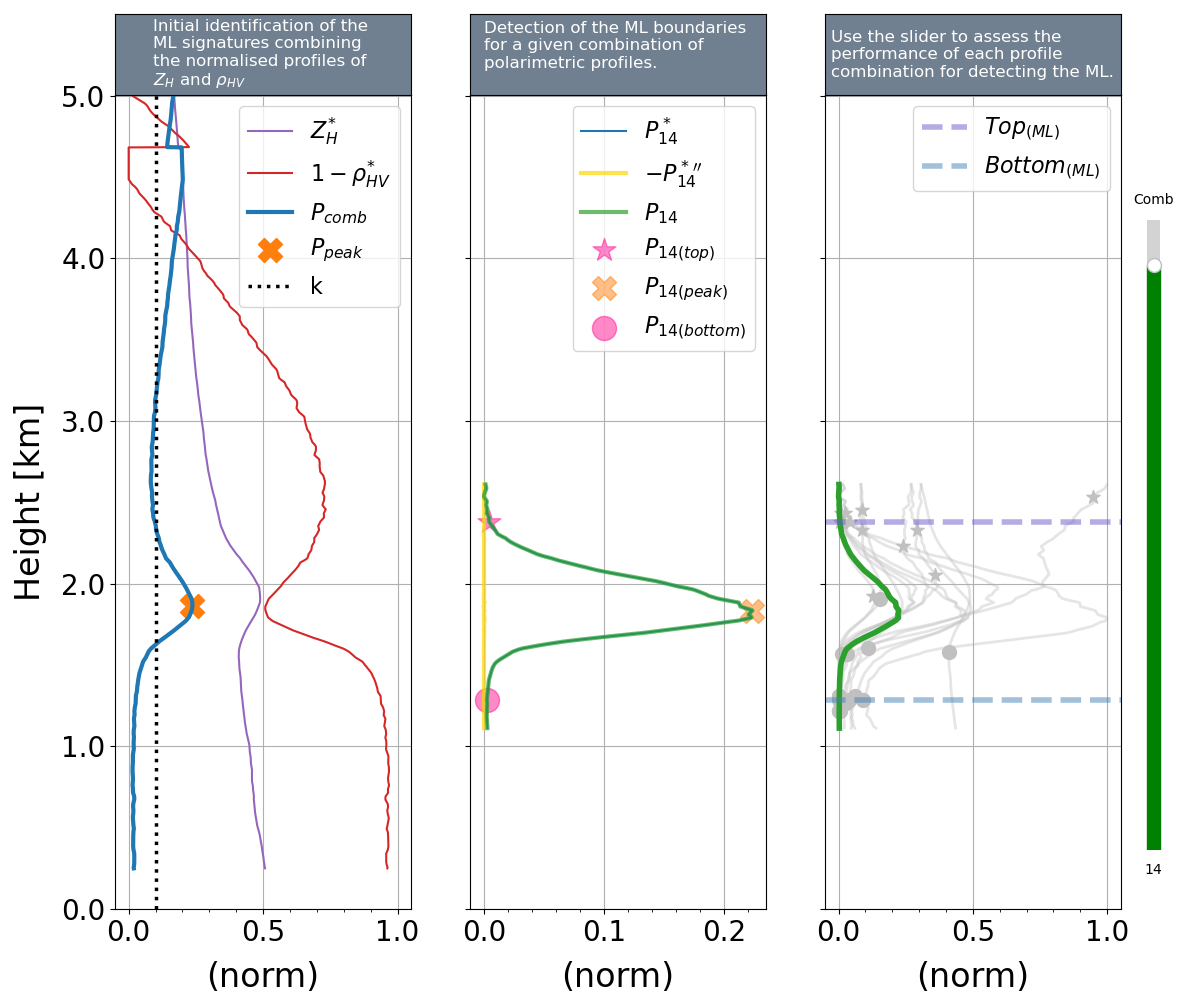

In [8]:
rmlyr = tp.ml.mlyr.MeltingLayer(rdqvps)
rmlyr.ml_detection(rdqvps, min_h=0.25, comb_id=14, param_k=0.1, plot_method=True)

## References

[1]
Met Office (2003): Met Office Rain Radar Data from the NIMROD System. NCAS British Atmospheric Data Centre, 2022. http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499


[2]
Tobin, D. M., & Kumjian, M. R. (2017). Polarimetric Radar and Surface-Based Precipitation-Type Observations of Ice Pellet to Freezing Rain Transitions, Weather and Forecasting, 32(6), 2065-2082. https://doi.org/10.1175/WAF-D-17-0054.1